# Self-Reconstruction Multi-Modal Autoencoder

This notebook implements the original architecture where:
- Image features are reconstructed by the image autoencoder
- Text features are reconstructed by the text autoencoder  
- Latent spaces are aligned using **either MSE or contrastive loss**

This forces the shared latent space to capture aligned representations.

**Prerequisites:** Run `Feature_Extraction_Batch.ipynb` first to generate the required .npy files.

In [53]:
# Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random
import csv
from datetime import datetime

## 1. Load Pre-extracted Features

We'll use the features already extracted from the Feature_Extraction notebook:
- Image features: ResNet50 (2048-dim)
- Caption features: BERT (768-dim)

In [54]:
# Load the pre-split data
image_train = np.load("train_image_features.npy")
caption_train = np.load("train_caption_features.npy")
cap2img_train = np.load("train_caption_to_image.npy")

image_val = np.load("val_image_features.npy")
caption_val = np.load("val_caption_features.npy")
cap2img_val = np.load("val_caption_to_image.npy")

image_test = np.load("test_image_features.npy")
caption_test = np.load("test_caption_features.npy")
cap2img_test = np.load("test_caption_to_image.npy")

print("Train shapes:", image_train.shape, caption_train.shape, cap2img_train.shape)
print("Val shapes:", image_val.shape, caption_val.shape, cap2img_val.shape)
print("Test shapes:", image_test.shape, caption_test.shape, cap2img_test.shape)

Train shapes: (5663, 2048) (28315, 768) (28315,)
Val shapes: (1214, 2048) (6070, 768) (6070,)
Test shapes: (1214, 2048) (6070, 768) (6070,)


## 2. Normalize Features

Normalize using training set statistics

In [55]:
# Compute normalization parameters from training set
img_mean = image_train.mean(axis=0, keepdims=True)
img_std = image_train.std(axis=0, keepdims=True) + 1e-6

txt_mean = caption_train.mean(axis=0, keepdims=True)
txt_std = caption_train.std(axis=0, keepdims=True) + 1e-6

# Apply normalization
def normalize_images(x):
    return (x - img_mean) / img_std

def normalize_texts(x):
    return (x - txt_mean) / txt_std

image_train = normalize_images(image_train)
image_val = normalize_images(image_val)
image_test = normalize_images(image_test)

caption_train = normalize_texts(caption_train)
caption_val = normalize_texts(caption_val)
caption_test = normalize_texts(caption_test)

print("Normalization complete!")

Normalization complete!


## 3. Dataset and DataLoader

Pairs captions with their corresponding images

In [56]:
class CaptionImagePairedDataset(Dataset):
    """
    Iterates over captions. For index i, returns:
      caption_features[i], image_features[caption_to_image_idx[i]]
    """
    def __init__(self, caption_feats, image_feats, caption_to_image_idx):
        assert len(caption_feats) == len(caption_to_image_idx)
        self.caption_feats = caption_feats.astype(np.float32)
        self.image_feats = image_feats.astype(np.float32)
        self.cap2img = caption_to_image_idx.astype(np.int64)

    def __len__(self):
        return len(self.caption_feats)

    def __getitem__(self, idx):
        cap = self.caption_feats[idx]
        img = self.image_feats[self.cap2img[idx]]
        return {"image": torch.from_numpy(img), "caption": torch.from_numpy(cap)}

## 4. Configuration

**Choose your loss function here:** Set `LOSS_TYPE` to either `"mse"` or `"contrastive"`

In [57]:
# ============================================================
# CHOOSE YOUR LOSS FUNCTION
# ============================================================
LOSS_TYPE = "contrastive"  # Change to "contrastive" to use contrastive loss

# ============================================================
# Model Configuration - MODIFY THESE FOR EXPERIMENTS
# ============================================================
config = {
    "latent_dim": 512,
    "img_input_dim": 2048,
    "txt_input_dim": 768,
    "img_hidden": 1024,
    "txt_hidden": 512,
    "batch_size": 256,
    "lr": 5e-4,
    "weight_decay": 1e-5,
    "epochs": 20,
    "lambda_align": 1.0,
    "temperature": 0.07,  # (only used for contrastive loss)
    "dropout": 0.25,
    "loss_type": LOSS_TYPE,
    "seed": 42,
}

# ============================================================
# Experiment Naming and Directory Setup
# ============================================================
# Create descriptive experiment name based on key hyperparameters
experiment_name = f"bs{config['batch_size']}_lamb{config['lambda_align']}_temp{config['temperature']}_drop{config['dropout']}"

# Set checkpoint directory with experiment name
if LOSS_TYPE == "mse":
    base_dir = "./corr_ae_checkpoints_mse"
elif LOSS_TYPE == "contrastive":
    base_dir = "./corr_ae_checkpoints_contrastive"
else:
    raise ValueError("LOSS_TYPE must be 'mse' or 'contrastive'")

checkpoint_dir = os.path.join(base_dir, experiment_name)
config["checkpoint_dir"] = checkpoint_dir

print(f"Using {LOSS_TYPE.upper()} loss")
print(f"Experiment: {experiment_name}")
print(f"Checkpoints: {checkpoint_dir}")

# Set seed
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Create checkpoint directory
os.makedirs(config["checkpoint_dir"], exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using CONTRASTIVE loss
Experiment: bs256_lamb1.0_temp0.07_drop0.25
Checkpoints: ./corr_ae_checkpoints_contrastive/bs256_lamb1.0_temp0.07_drop0.25
Using device: cpu


## 5. Self-Reconstruction Autoencoder Architecture

Key idea:
- Image encoder → latent → Image decoder (outputs image features)
- Text encoder → latent → Text decoder (outputs text features)

Both autoencoders output the same latent dimension, with alignment enforced by loss function.

In [58]:
class ImageAE(nn.Module):
    """Image autoencoder: encodes and decodes image features"""
    def __init__(self, input_dim=2048, hidden_dim=1024, latent_dim=512, dropout=0.0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return z, recon


class TextAE(nn.Module):
    """Text autoencoder: encodes and decodes text features"""
    def __init__(self, input_dim=768, hidden_dim=512, latent_dim=512, dropout=0.0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return z, recon


print("Model architecture defined!")

Model architecture defined!


## 6. Loss Functions

In [59]:
def contrastive_loss(z_img, z_txt, temperature=0.07):
    """
    Contrastive loss to align image and text embeddings.
    Encourages matching pairs to be close and non-matching pairs to be far.
    """
    # Normalize embeddings with epsilon for numerical stability
    z_img_norm = F.normalize(z_img, dim=1, eps=1e-8)
    z_txt_norm = F.normalize(z_txt, dim=1, eps=1e-8)
    
    # Compute similarity matrix
    logits = torch.matmul(z_img_norm, z_txt_norm.T) / temperature
    
    # Labels: diagonal elements are positive pairs
    labels = torch.arange(z_img.size(0)).to(z_img.device)
    
    # Cross-entropy in both directions
    loss_i2t = F.cross_entropy(logits, labels)
    loss_t2i = F.cross_entropy(logits.T, labels)
    
    return (loss_i2t + loss_t2i) / 2


# Reconstruction loss
recon_loss_fn = nn.MSELoss()

# Alignment loss - chosen based on LOSS_TYPE
if config["loss_type"] == "mse":
    align_loss_fn = nn.MSELoss()
    print("Using MSE for alignment loss")
else:
    align_loss_fn = None  # Will use contrastive_loss function
    print("Using contrastive loss for alignment")

print("Loss functions defined!")

Using contrastive loss for alignment
Loss functions defined!


## 7. Initialize Models and Optimizer

In [60]:
# Instantiate models with dropout
img_ae = ImageAE(
    input_dim=config["img_input_dim"],
    hidden_dim=config["img_hidden"],
    latent_dim=config["latent_dim"],
    dropout=config["dropout"]
).to(device)

txt_ae = TextAE(
    input_dim=config["txt_input_dim"],
    hidden_dim=config["txt_hidden"],
    latent_dim=config["latent_dim"],
    dropout=config["dropout"]
).to(device)

# Optimizer for all parameters
params = list(img_ae.parameters()) + list(txt_ae.parameters())
optimizer = Adam(params, lr=config["lr"], weight_decay=config["weight_decay"])

print(f"Models initialized with {sum(p.numel() for p in params):,} total parameters")
print(f"Dropout: {config['dropout']}")

Models initialized with 6,560,512 total parameters
Dropout: 0.25


## 8. Create DataLoaders

In [61]:
train_dataset = CaptionImagePairedDataset(caption_train, image_train, cap2img_train)
val_dataset = CaptionImagePairedDataset(caption_val, image_val, cap2img_val)

train_loader = DataLoader(
    train_dataset, 
    batch_size=config["batch_size"], 
    shuffle=True, 
    num_workers=0
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=config["batch_size"], 
    shuffle=False, 
    num_workers=0
)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train batches: 111, Val batches: 24


## 9. Training Loop

Self-reconstruction:
- Image → img_ae → z_img, img_recon (reconstructs itself)
- Text → txt_ae → z_txt, txt_recon (reconstructs itself)

Plus alignment loss (MSE or contrastive) to align z_img and z_txt

In [62]:
def run_epoch(loader, training=True):
    if training:
        img_ae.train()
        txt_ae.train()
    else:
        img_ae.eval()
        txt_ae.eval()

    total_recon_img = 0.0
    total_recon_txt = 0.0
    total_align = 0.0
    total_loss = 0.0
    n_samples = 0

    pbar = tqdm(loader, desc="train" if training else "val")
    with torch.set_grad_enabled(training):
        for batch in pbar:
            imgs = batch["image"].to(device)
            caps = batch["caption"].to(device)
            batch_size = imgs.shape[0]

            # Forward pass: self-reconstruction
            z_img, img_recon = img_ae(imgs)
            z_txt, txt_recon = txt_ae(caps)

            # Reconstruction losses
            L_img = recon_loss_fn(img_recon, imgs)
            L_txt = recon_loss_fn(txt_recon, caps)
            
            # Alignment loss (applied directly to latent z)
            if config["loss_type"] == "mse":
                L_align = align_loss_fn(z_img, z_txt)
            else:  # contrastive
                L_align = contrastive_loss(z_img, z_txt, temperature=config["temperature"])

            # Total loss
            loss = L_img + L_txt + config["lambda_align"] * L_align

            if training:
                optimizer.zero_grad()
                loss.backward()
                # Gradient clipping for numerical stability
                torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
                optimizer.step()

            # Accumulate metrics
            total_recon_img += L_img.item() * batch_size
            total_recon_txt += L_txt.item() * batch_size
            total_align += L_align.item() * batch_size
            total_loss += loss.item() * batch_size
            n_samples += batch_size

            pbar.set_postfix({
                "loss": f"{total_loss / n_samples:.4f}",
                "Limg": f"{total_recon_img / n_samples:.4f}",
                "Ltxt": f"{total_recon_txt / n_samples:.4f}",
                "Lalign": f"{total_align / n_samples:.4f}"
            })

    return {
        "loss": total_loss / n_samples,
        "Limg": total_recon_img / n_samples,
        "Ltxt": total_recon_txt / n_samples,
        "Lalign": total_align / n_samples
    }

## 10. Train the Model

In [63]:
best_val_loss = float("inf")

for epoch in range(1, config["epochs"] + 1):
    print(f"\n=== Epoch {epoch}/{config['epochs']} ===")
    train_metrics = run_epoch(train_loader, training=True)
    val_metrics = run_epoch(val_loader, training=False)

    print(f"Train loss: {train_metrics['loss']:.4f} | Val loss: {val_metrics['loss']:.4f}")

    # Save checkpoint every epoch
    ckpt = {
        "epoch": epoch,
        "img_state": img_ae.state_dict(),
        "txt_state": txt_ae.state_dict(),
        "optimizer": optimizer.state_dict(),
        "train_metrics": train_metrics,
        "val_metrics": val_metrics,
        "config": config
    }
    ckpt_path = os.path.join(config["checkpoint_dir"], f"corr_ae_epoch{epoch}.pt")
    torch.save(ckpt, ckpt_path)

    # Save best checkpoint
    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        torch.save(ckpt, os.path.join(config["checkpoint_dir"], "corr_ae_best.pt"))
        print("Saved best checkpoint.")

print("Training finished!")


=== Epoch 1/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 197.06it/s, loss=4.2077, Limg=0.4950, Ltxt=0.3669, Lalign=3.3457]


Train loss: 4.7110 | Val loss: 4.2077
Saved best checkpoint.

=== Epoch 2/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 181.42it/s, loss=3.9451, Limg=0.3954, Ltxt=0.3003, Lalign=3.2494]


Train loss: 3.2591 | Val loss: 3.9451
Saved best checkpoint.

=== Epoch 3/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 185.84it/s, loss=3.8602, Limg=0.3472, Ltxt=0.2684, Lalign=3.2446]


Train loss: 2.7329 | Val loss: 3.8602
Saved best checkpoint.

=== Epoch 4/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 150.28it/s, loss=3.7985, Limg=0.3187, Ltxt=0.2482, Lalign=3.2316]


Train loss: 2.3942 | Val loss: 3.7985
Saved best checkpoint.

=== Epoch 5/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 181.50it/s, loss=3.7695, Limg=0.2979, Ltxt=0.2369, Lalign=3.2347]


Train loss: 2.1591 | Val loss: 3.7695
Saved best checkpoint.

=== Epoch 6/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 189.77it/s, loss=3.7341, Limg=0.2824, Ltxt=0.2261, Lalign=3.2256]


Train loss: 1.9828 | Val loss: 3.7341
Saved best checkpoint.

=== Epoch 7/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 183.15it/s, loss=3.7288, Limg=0.2694, Ltxt=0.2173, Lalign=3.2421]


Train loss: 1.8468 | Val loss: 3.7288
Saved best checkpoint.

=== Epoch 8/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 182.18it/s, loss=3.7014, Limg=0.2606, Ltxt=0.2115, Lalign=3.2293]


Train loss: 1.7402 | Val loss: 3.7014
Saved best checkpoint.

=== Epoch 9/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 186.19it/s, loss=3.6860, Limg=0.2535, Ltxt=0.2069, Lalign=3.2256]


Train loss: 1.6470 | Val loss: 3.6860
Saved best checkpoint.

=== Epoch 10/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 177.64it/s, loss=3.6943, Limg=0.2458, Ltxt=0.2045, Lalign=3.2439]


Train loss: 1.5676 | Val loss: 3.6943

=== Epoch 11/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 184.27it/s, loss=3.6828, Limg=0.2420, Ltxt=0.1986, Lalign=3.2421]


Train loss: 1.5020 | Val loss: 3.6828
Saved best checkpoint.

=== Epoch 12/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 187.52it/s, loss=3.6978, Limg=0.2398, Ltxt=0.1987, Lalign=3.2593]


Train loss: 1.4496 | Val loss: 3.6978

=== Epoch 13/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 182.67it/s, loss=3.6783, Limg=0.2363, Ltxt=0.1938, Lalign=3.2482]


Train loss: 1.3952 | Val loss: 3.6783
Saved best checkpoint.

=== Epoch 14/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 185.05it/s, loss=3.6746, Limg=0.2337, Ltxt=0.1934, Lalign=3.2476]


Train loss: 1.3554 | Val loss: 3.6746
Saved best checkpoint.

=== Epoch 15/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 179.84it/s, loss=3.6612, Limg=0.2303, Ltxt=0.1916, Lalign=3.2393]


Train loss: 1.3103 | Val loss: 3.6612
Saved best checkpoint.

=== Epoch 16/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 172.78it/s, loss=3.6834, Limg=0.2309, Ltxt=0.1894, Lalign=3.2631]


Train loss: 1.2827 | Val loss: 3.6834

=== Epoch 17/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 171.81it/s, loss=3.6720, Limg=0.2275, Ltxt=0.1874, Lalign=3.2571]


Train loss: 1.2433 | Val loss: 3.6720

=== Epoch 18/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 181.99it/s, loss=3.6742, Limg=0.2279, Ltxt=0.1865, Lalign=3.2598]


Train loss: 1.2159 | Val loss: 3.6742

=== Epoch 19/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 179.24it/s, loss=3.6775, Limg=0.2258, Ltxt=0.1848, Lalign=3.2669]


Train loss: 1.1883 | Val loss: 3.6775

=== Epoch 20/20 ===


val: 100%|██████████| 24/24 [00:00<00:00, 181.34it/s, loss=3.6870, Limg=0.2249, Ltxt=0.1831, Lalign=3.2790]


Train loss: 1.1680 | Val loss: 3.6870
Training finished!


## 11. Evaluation: Load Best Model and Compute Retrieval Metrics

In [64]:
# Load best checkpoint
best_ckpt_path = os.path.join(config["checkpoint_dir"], "corr_ae_best.pt")
ckpt = torch.load(best_ckpt_path, map_location=device)

img_ae.load_state_dict(ckpt["img_state"])
txt_ae.load_state_dict(ckpt["txt_state"])
img_ae.eval()
txt_ae.eval()

print(f"Loaded best checkpoint from epoch {ckpt['epoch']}")

Loaded best checkpoint from epoch 15


In [65]:
def encode_features(image_feats, caption_feats):
    """
    Encode images and captions into latent space.
    """
    with torch.no_grad():
        # Encode images
        Z_imgs = []
        for i in range(0, image_feats.shape[0], 256):
            batch = torch.from_numpy(image_feats[i:i+256]).float().to(device)
            z, _ = img_ae(batch)
            Z_imgs.append(z.cpu().numpy())
        Z_imgs = np.concatenate(Z_imgs, axis=0)

        # Encode captions
        Z_caps = []
        for i in range(0, caption_feats.shape[0], 256):
            batch = torch.from_numpy(caption_feats[i:i+256]).float().to(device)
            z, _ = txt_ae(batch)
            Z_caps.append(z.cpu().numpy())
        Z_caps = np.concatenate(Z_caps, axis=0)

    return Z_imgs, Z_caps

In [66]:
def retrieval_metrics(Z_caps, Z_imgs, caption_to_image_idx):
    """
    Compute Recall@K metrics for image retrieval given captions.
    """
    sims = cosine_similarity(Z_caps, Z_imgs)
    ranks = []
    for i, true_img_idx in enumerate(caption_to_image_idx):
        sim_scores = sims[i]
        sorted_indices = np.argsort(-sim_scores)
        rank = np.where(sorted_indices == true_img_idx)[0][0] + 1
        ranks.append(rank)

    ranks = np.array(ranks)
    return {
        "Recall@1": np.mean(ranks <= 1),
        "Recall@5": np.mean(ranks <= 5),
        "Recall@10": np.mean(ranks <= 10),
        "MedianRank": np.median(ranks)
    }

### Validation Set Metrics

In [67]:
print("Encoding validation set...")
Z_imgs_val, Z_caps_val = encode_features(image_val, caption_val)
print(f"Encoded shapes: {Z_imgs_val.shape}, {Z_caps_val.shape}")

metrics_val = retrieval_metrics(Z_caps_val, Z_imgs_val, cap2img_val)
print("\nValidation Set Metrics:")
for k, v in metrics_val.items():
    print(f"  {k}: {v:.4f}")

/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Encoding validation set...
Encoded shapes: (1214, 512), (6070, 512)

Validation Set Metrics:
  Recall@1: 0.1387
  Recall@5: 0.3535
  Recall@10: 0.4898
  MedianRank: 11.0000


### Test Set Metrics

In [68]:
print("Encoding test set...")
Z_imgs_test, Z_caps_test = encode_features(image_test, caption_test)
print(f"Encoded shapes: {Z_imgs_test.shape}, {Z_caps_test.shape}")

metrics_test = retrieval_metrics(Z_caps_test, Z_imgs_test, cap2img_test)
print("\nTest Set Metrics:")
for k, v in metrics_test.items():
    print(f"  {k}: {v:.4f}")

Encoding test set...
Encoded shapes: (1214, 512), (6070, 512)


/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



Test Set Metrics:
  Recall@1: 0.1361
  Recall@5: 0.3720
  Recall@10: 0.5043
  MedianRank: 10.0000


## 12. Visualization (Optional)

Visualize some retrieval results

In [69]:
# Load additional data for visualization
df = pd.read_csv('/Users/sabrinafowler/Deep-Learning-Divas/archive/captions.txt')
image_names = np.load('flickr8k_image_names.npy')

# Recreate splits to get validation masks
n_images = len(image_names)
indices = np.arange(n_images)
train_idx, temp_idx = train_test_split(indices, test_size=0.30, random_state=42, shuffle=True)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42, shuffle=True)

# Create masks
caption_to_image_idx = df["image"].map({name: i for i, name in enumerate(image_names)}).values.astype(int)
val_mask = np.isin(caption_to_image_idx, val_idx)

# Get validation caption texts and image names
val_caption_texts = df["caption"].values[val_mask]
val_image_names = np.array([image_names[i] for i in val_idx])

print(f"Loaded {len(val_caption_texts)} validation captions")

Loaded 6070 validation captions



=== Retrieval Examples ===

CAPTION: Baseball player throwing the baseball .
TRUE IMAGE: 3561734666_344f260cce.jpg (index 1186)


/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


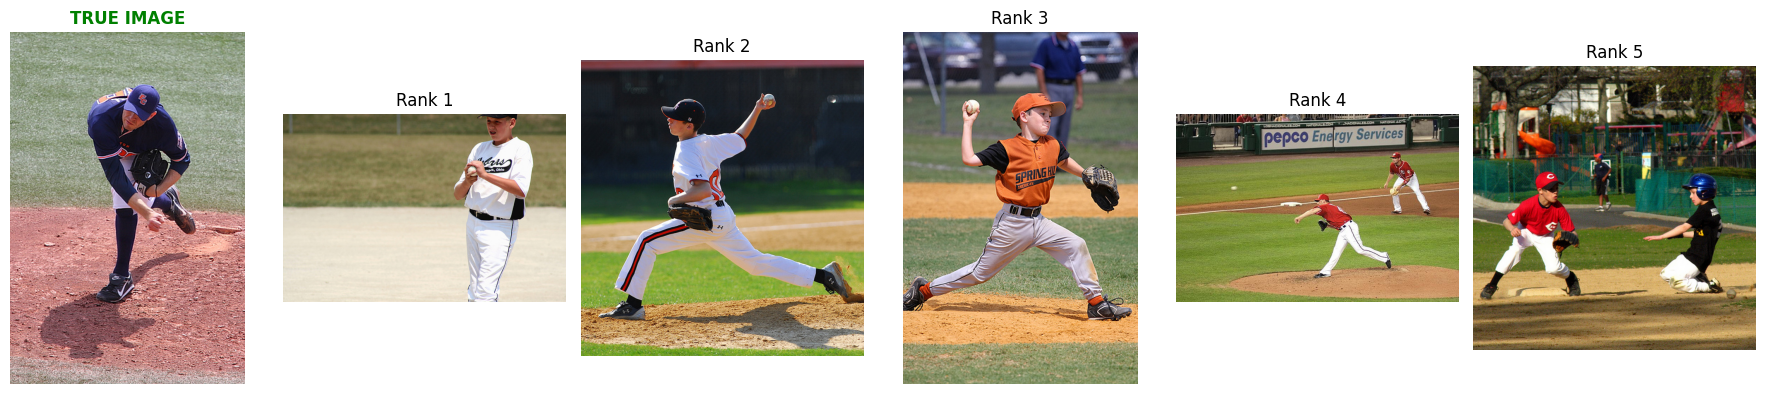


CAPTION: Two men in midair fighting in a professional wrestling ring .
TRUE IMAGE: 3181599388_68559cfc17.jpg (index 555)


/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


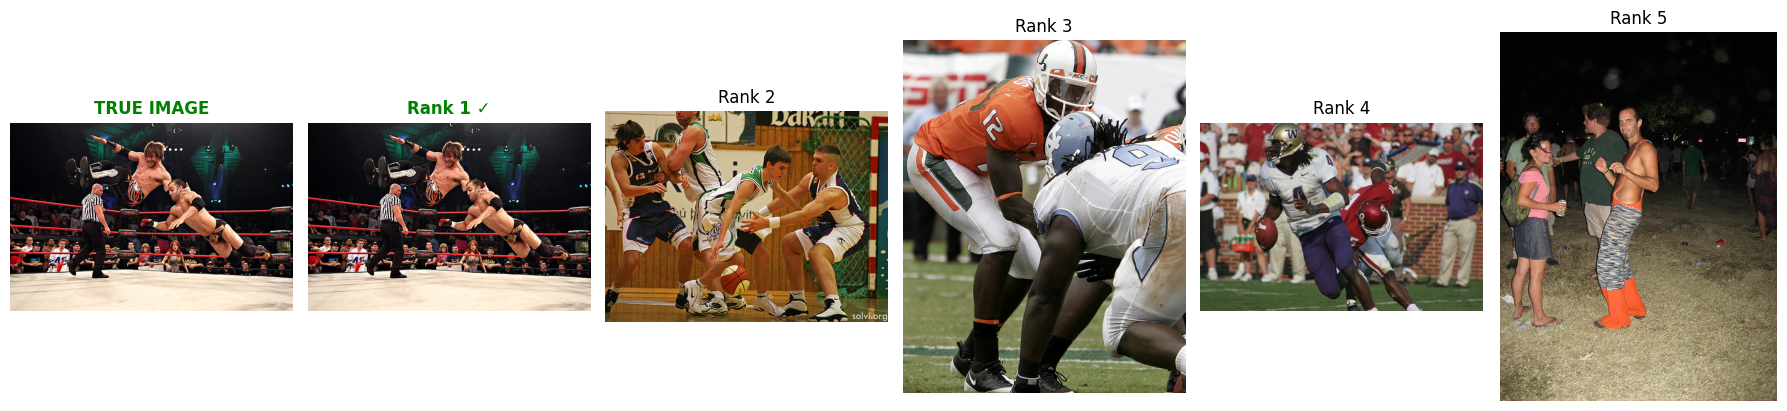

/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



CAPTION: Dog jumps over a man and catches a Frisbee in his mouth .
TRUE IMAGE: 825918657_d92f1761f4.jpg (index 105)


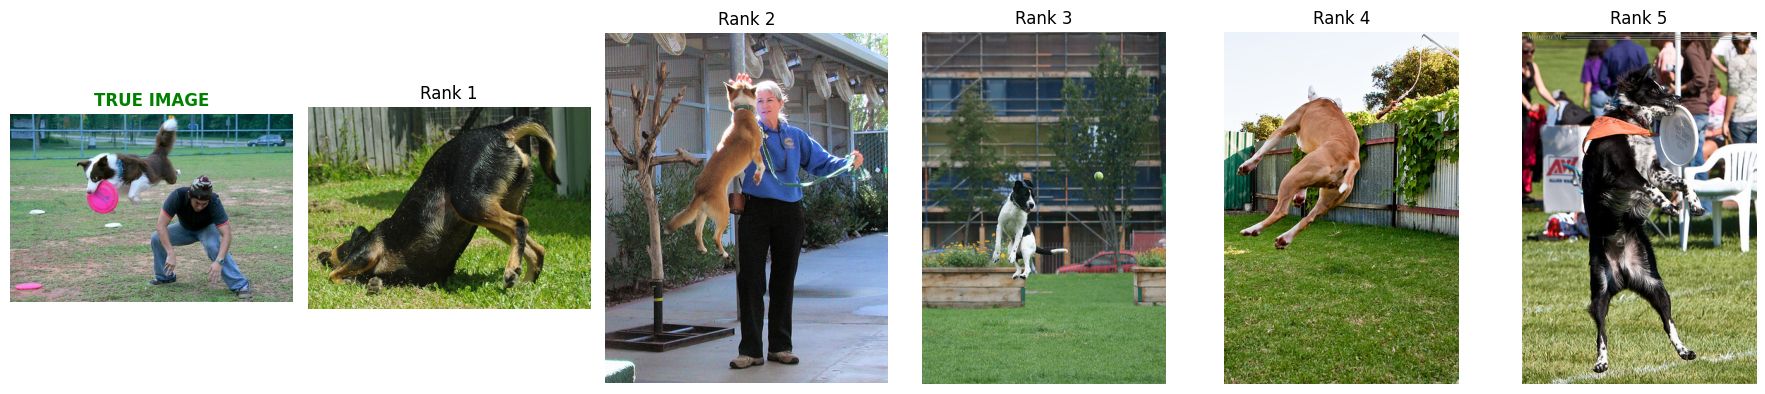

In [70]:
image_dir = "/Users/sabrinafowler/Deep-Learning-Divas/archive/Images"

def show_top_images_for_caption(caption_idx, top_k=5):
    """
    Show top-k retrieved validation images for a given caption index.
    """
    caption_embedding = Z_caps_val[caption_idx].reshape(1, -1)
    sims = cosine_similarity(caption_embedding, Z_imgs_val)[0]
    top_img_indices = np.argsort(-sims)[:top_k]

    print(f"\nCAPTION: {val_caption_texts[caption_idx]}")
    true_img_idx = cap2img_val[caption_idx]
    print(f"TRUE IMAGE: {val_image_names[true_img_idx]} (index {true_img_idx})")
    
    plt.figure(figsize=(18, 4))
    
    # Show true image
    true_img_name = val_image_names[true_img_idx]
    true_img_path = os.path.join(image_dir, true_img_name)
    try:
        true_img = Image.open(true_img_path)
        plt.subplot(1, top_k + 1, 1)
        plt.imshow(true_img)
        plt.axis('off')
        plt.title("TRUE IMAGE", fontweight='bold', color='green')
    except Exception as e:
        print(f"Could not open true image: {e}")
    
    # Show retrieved images
    for i, img_idx in enumerate(top_img_indices):
        img_name = val_image_names[img_idx]
        img_path = os.path.join(image_dir, img_name)
        try:
            img = Image.open(img_path)
        except Exception as e:
            print(f"Could not open {img_path}: {e}")
            continue
        
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(img)
        plt.axis('off')
        
        if img_idx == true_img_idx:
            plt.title(f"Rank {i+1} ✓", fontweight='bold', color='green')
        else:
            plt.title(f"Rank {i+1}")
    
    plt.tight_layout()
    plt.show()

# Show some random examples
print("\n=== Retrieval Examples ===")
for i in random.sample(range(len(Z_caps_val)), 3):
    show_top_images_for_caption(i, top_k=5)

/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sabri

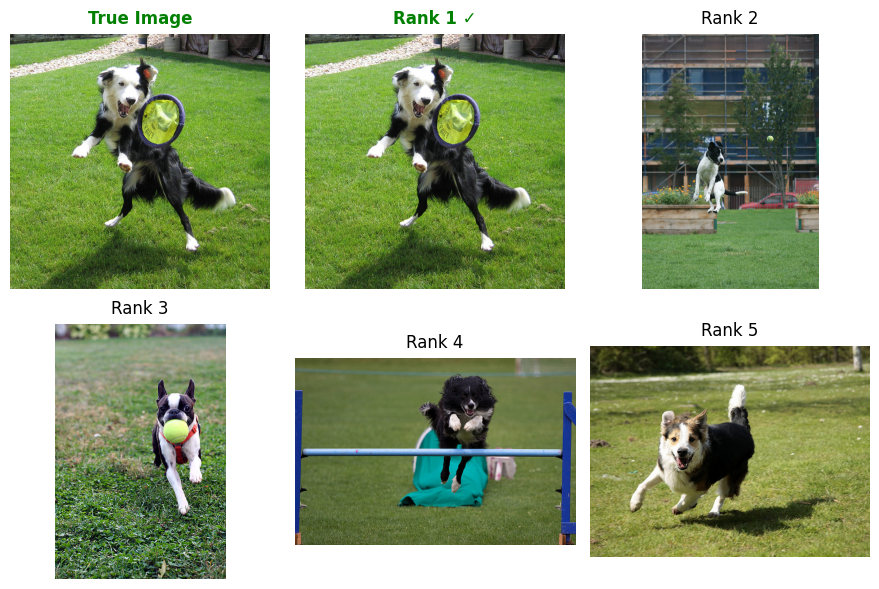


Caption: A black and white dog is attempting to catch a yellow and purple object in a low cut yard .
Saved figure to: retrievalex.png


In [74]:
# retrieval example formatted for slides
def create_slide_retrieval_figure(caption_idx, output_filename='wrestlingex.png'):
    """
    Create a clean, slide-ready figure showing retrieval results.
    Two rows: Top row has true image + ranks 1-2, bottom row has ranks 3-5.
    """
    caption_embedding = Z_caps_val[caption_idx].reshape(1, -1)
    sims = cosine_similarity(caption_embedding, Z_imgs_val)[0]
    top_img_indices = np.argsort(-sims)[:5]
    
    caption_text = val_caption_texts[caption_idx]
    true_img_idx = cap2img_val[caption_idx]
    
    # Create figure with 2 rows, 3 columns (more square aspect ratio)
    fig = plt.figure(figsize=(9, 6))
    fig.patch.set_facecolor('white')
    
    # Top row: True image (left) + Rank 1 (center) + Rank 2 (right)
    ax1 = plt.subplot(2, 3, 1)
    ax2 = plt.subplot(2, 3, 2)
    ax3 = plt.subplot(2, 3, 3)
    
    # Bottom row: Rank 3, 4, 5
    ax4 = plt.subplot(2, 3, 4)
    ax5 = plt.subplot(2, 3, 5)
    ax6 = plt.subplot(2, 3, 6)
    
    top_axes = [ax1, ax2, ax3]
    bottom_axes = [ax4, ax5, ax6]
    
    # Show true image in top-left
    true_img_name = val_image_names[true_img_idx]
    true_img_path = os.path.join(image_dir, true_img_name)
    try:
        true_img = Image.open(true_img_path)
        ax1.imshow(true_img)
        ax1.axis('off')
        ax1.set_title('True Image', fontsize=12, fontweight='bold', color='green', pad=8)
    except Exception as e:
        print(f"Could not load true image: {e}")
        ax1.axis('off')
    
    # Show top 5 retrieved images
    # Top row: ranks 1-2
    for i, (ax, img_idx) in enumerate(zip([ax2, ax3], top_img_indices[:2])):
        img_name = val_image_names[img_idx]
        img_path = os.path.join(image_dir, img_name)
        
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')
            
            rank = i + 1
            if img_idx == true_img_idx:
                ax.set_title(f'Rank {rank} ✓', fontsize=12, fontweight='bold', color='green', pad=8)
            else:
                ax.set_title(f'Rank {rank}', fontsize=12, pad=8)
        except Exception as e:
            print(f"Could not load image: {e}")
            ax.axis('off')
    
    # Bottom row: ranks 3-5
    for i, (ax, img_idx) in enumerate(zip(bottom_axes, top_img_indices[2:5])):
        img_name = val_image_names[img_idx]
        img_path = os.path.join(image_dir, img_name)
        
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')
            
            rank = i + 3
            if img_idx == true_img_idx:
                ax.set_title(f'Rank {rank} ✓', fontsize=12, fontweight='bold', color='green', pad=8)
            else:
                ax.set_title(f'Rank {rank}', fontsize=12, pad=8)
        except Exception as e:
            print(f"Could not load image: {e}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_filename, dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"\nCaption: {caption_text}")
    print(f"Saved figure to: {output_filename}")
    return caption_text

# Find a good example - look for captions where correct image is in top 5
np.random.seed(42)
good_examples = []

for idx in range(min(100, len(Z_caps_val))):
    caption_embedding = Z_caps_val[idx].reshape(1, -1)
    sims = cosine_similarity(caption_embedding, Z_imgs_val)[0]
    top_5_indices = np.argsort(-sims)[:5]
    true_idx = cap2img_val[idx]
    
    if true_idx in top_5_indices:
        rank = np.where(top_5_indices == true_idx)[0][0] + 1
        good_examples.append((idx, rank))

# Use first example where correct image is ranked 1st
best_idx = next((idx for idx, rank in good_examples if rank == 1), good_examples[0][0])

caption_text = create_slide_retrieval_figure(best_idx, 'retrievalex.png')

## 13. Recover Hyperparameter Search Results

Load all saved checkpoints and extract validation metrics

In [71]:
# Recover hyperparameter search metrics from saved checkpoints
import glob

checkpoint_paths = glob.glob("corr_ae_checkpoints_contrastive/*/corr_ae_best.pt")
results = []

for ckpt_path in sorted(checkpoint_paths):
    ckpt = torch.load(ckpt_path, map_location=device)
    config_info = ckpt['config']
    val_metrics = ckpt['val_metrics']

    # Parse experiment name from path
    exp_name = os.path.basename(os.path.dirname(ckpt_path))

    results.append({
        'experiment': exp_name,
        'batch_size': config_info.get('batch_size', 'N/A'),
        'lambda_align': config_info.get('lambda_align', 'N/A'),
        'temperature': config_info.get('temperature', 'N/A'),
        'dropout': config_info.get('dropout', 'N/A'),
        'lr': config_info.get('lr', 'N/A'),
        'val_loss': val_metrics['loss'],
        'val_Limg': val_metrics['Limg'],
        'val_Ltxt': val_metrics['Ltxt'],
        'val_Lalign': val_metrics['Lalign'],
        'epoch': ckpt['epoch']
    })

# Create DataFrame and display
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('val_loss')
print(f"\n=== Hyperparameter Search Results ({len(results)} configurations) ===\n")
print(results_df.to_string(index=False))
print(f"\nBest configuration: {results_df.iloc[0]['experiment']}")
print(f"Best validation loss: {results_df.iloc[0]['val_loss']:.4f}")


=== Hyperparameter Search Results (10 configurations) ===

                              experiment  batch_size  lambda_align  temperature  dropout     lr  val_loss  val_Limg  val_Ltxt  val_Lalign  epoch
          bs128_lamb1.0_temp0.07_drop0.0         128           1.0         0.07     0.00 0.0010  3.348409  0.259095  0.162901    2.926414      9
          bs128_lamb1.0_temp0.07_drop0.3         128           1.0         0.07     0.30 0.0010  3.395392  0.342812  0.209517    2.843063     17
         bs256_lamb1.0_temp0.07_drop0.25         256           1.0         0.07     0.25 0.0005  3.661177  0.230260  0.191632    3.239285     15
bs256_lamb1.0_temp0.07_drop0.25_lr0.0005         256           1.0         0.07     0.25 0.0005  3.661177  0.230260  0.191632    3.239285     15
          bs256_lamb1.0_temp0.07_drop0.2         256           1.0         0.07     0.20 0.0005  3.678052  0.243129  0.200154    3.234769      9
          bs256_lamb1.0_temp0.07_drop0.3         256           1.0    

In [72]:
# Evaluate all configurations on test set
test_results = []

print("\nEvaluating all checkpoints on test set...")
for _, row in tqdm(results_df.iterrows(), total=len(results_df), desc="Evaluating"):
    exp_name = row['experiment']
    ckpt_path = f"corr_ae_checkpoints_contrastive/{exp_name}/corr_ae_best.pt"

    # Load checkpoint
    ckpt = torch.load(ckpt_path, map_location=device)
    img_ae.load_state_dict(ckpt["img_state"])
    txt_ae.load_state_dict(ckpt["txt_state"])
    img_ae.eval()
    txt_ae.eval()

    # Encode and evaluate
    Z_imgs_test_temp, Z_caps_test_temp = encode_features(image_test, caption_test)
    metrics_test_temp = retrieval_metrics(Z_caps_test_temp, Z_imgs_test_temp, cap2img_test)

    test_results.append({
        'experiment': exp_name,
        'R@1': metrics_test_temp['Recall@1'],
        'R@5': metrics_test_temp['Recall@5'],
        'R@10': metrics_test_temp['Recall@10'],
        'MedR': metrics_test_temp['MedianRank']
    })

test_df = pd.DataFrame(test_results)
test_df = test_df.sort_values('R@10', ascending=False)
print("\n=== Test Set Performance ===\n")
print(test_df.to_string(index=False))
print(f"\nBest test R@10: {test_df.iloc[0]['R@10']*100:.1f}% ({test_df.iloc[0]['experiment']})")


Evaluating all checkpoints on test set...


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
Evaluating:  10%|█         | 1/10 [00:00<00:03,  2.66it/s]/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sabrinafowler/miniconda3/envs/DLD/lib/python3.10/site-packages/


=== Test Set Performance ===

                              experiment      R@1      R@5     R@10  MedR
         bs256_lamb1.0_temp0.07_drop0.25 0.136079 0.371993 0.504283  10.0
bs256_lamb1.0_temp0.07_drop0.25_lr0.0005 0.136079 0.371993 0.504283  10.0
          bs256_lamb1.0_temp0.07_drop0.2 0.135091 0.361614 0.500494  10.0
          bs256_lamb1.0_temp0.07_drop0.3 0.135750 0.362932 0.498353  11.0
          bs128_lamb1.0_temp0.07_drop0.3 0.134102 0.369852 0.497858  11.0
          bs512_lamb1.0_temp0.07_drop0.3 0.133937 0.375783 0.495222  11.0
          bs256_lamb1.0_temp0.05_drop0.3 0.133114 0.355519 0.489621  11.0
 bs256_lamb1.0_temp0.07_drop0.25_lr0.002 0.134102 0.359967 0.489127  11.0
          bs128_lamb1.0_temp0.07_drop0.0 0.119275 0.334926 0.472652  12.0
          bs256_lamb2.0_temp0.05_drop0.3 0.117957 0.315486 0.454530  13.0

Best test R@10: 50.4% (bs256_lamb1.0_temp0.07_drop0.25)
